In [1]:
#!jupyter nbconvert --to script SVM_Training.ipynb
from __future__ import print_function
import sys
import os
import numpy as np
import shutil
sys.path.insert(0, os.path.join('..', '..'))
import datetime
import sklearn.metrics
from matplotlib import pyplot as plt
import pandas
from multiprocessing import Pool
from contextlib import closing
import pickle as pl
import matplotlib
from gait_analysis.utils.data_loading import mkdir_p
from gait_analysis.plotting import barplot, FigSaver
from gait_analysis import settings as S
%matplotlib inline

** choosing matplotlib style **

# 0. Settings

In [11]:
exp_folder = r'/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/'
auswertung_folder = exp_folder
mkdir_p(os.path.join(auswertung_folder))
sub_folders = [os.path.join(exp_folder, o) for o in os.listdir(exp_folder) if os.path.isdir(os.path.join(exp_folder, o))]

report_folder = os.path.join(S.exp_reports_root, 'exp_1')
mkdir_p(report_folder)
f_saver = FigSaver(report_folder, plt_savefig_kwargs={'dpi' : 250})

## 0.1 options tuple from launcher

(temporal_extent, body_keypoints_include_list)

In [12]:
from itertools import product
body_keypoints_include_list=[
    'LAnkle',
    'RAnkle',
    'LKnee',
    'RKnee',
    'RHip',
    'LHip',
]
all_options = [body_keypoints_include_list[:i] for i in range(1, len(body_keypoints_include_list))]
opt_tuple_list = list(product(range(6), all_options))
print(opt_tuple_list[0])

def opt_tuple2string(opt_tuple):
    return '{}, {}'.format(opt_tuple[0], ' + '.join(opt_tuple[1]))
    

opt_tuple_string_list = list(map(opt_tuple2string, opt_tuple_list))
print(opt_tuple_string_list[1])

(0, ['LAnkle'])
0, LAnkle + RAnkle


# 1.0 Calculate over all accuracy, precision and recall

In [13]:
metrics = [
    sklearn.metrics.accuracy_score,
    sklearn.metrics.precision_score,
    sklearn.metrics.recall_score,
]
metric_titles = [
    'Accuracy',
    'Precision',
    'Recall',
]



In [14]:
def process_subfolders(sub_folders):    
    def process_subfolder(sub_folder):
        df = pandas.read_pickle(os.path.join(sub_folder, "results.pickle"))
        data_frame = df
        cols = data_frame.columns    
        all_targets = np.hstack([np.array(data_frame[idx]['target']) for idx in cols])
        all_predictions = np.hstack([np.array(data_frame[idx]['prediction']).squeeze()] for idx in cols).squeeze()

        output = {
            'targets' : all_targets,
            'predictions' : all_predictions,
        }
        return output

    outputs = list(map(process_subfolder, sub_folders))

    return outputs

output = process_subfolders(sub_folders)


<gait_analysis.plotting.FigSaver instance at 0x7f5a35728680>

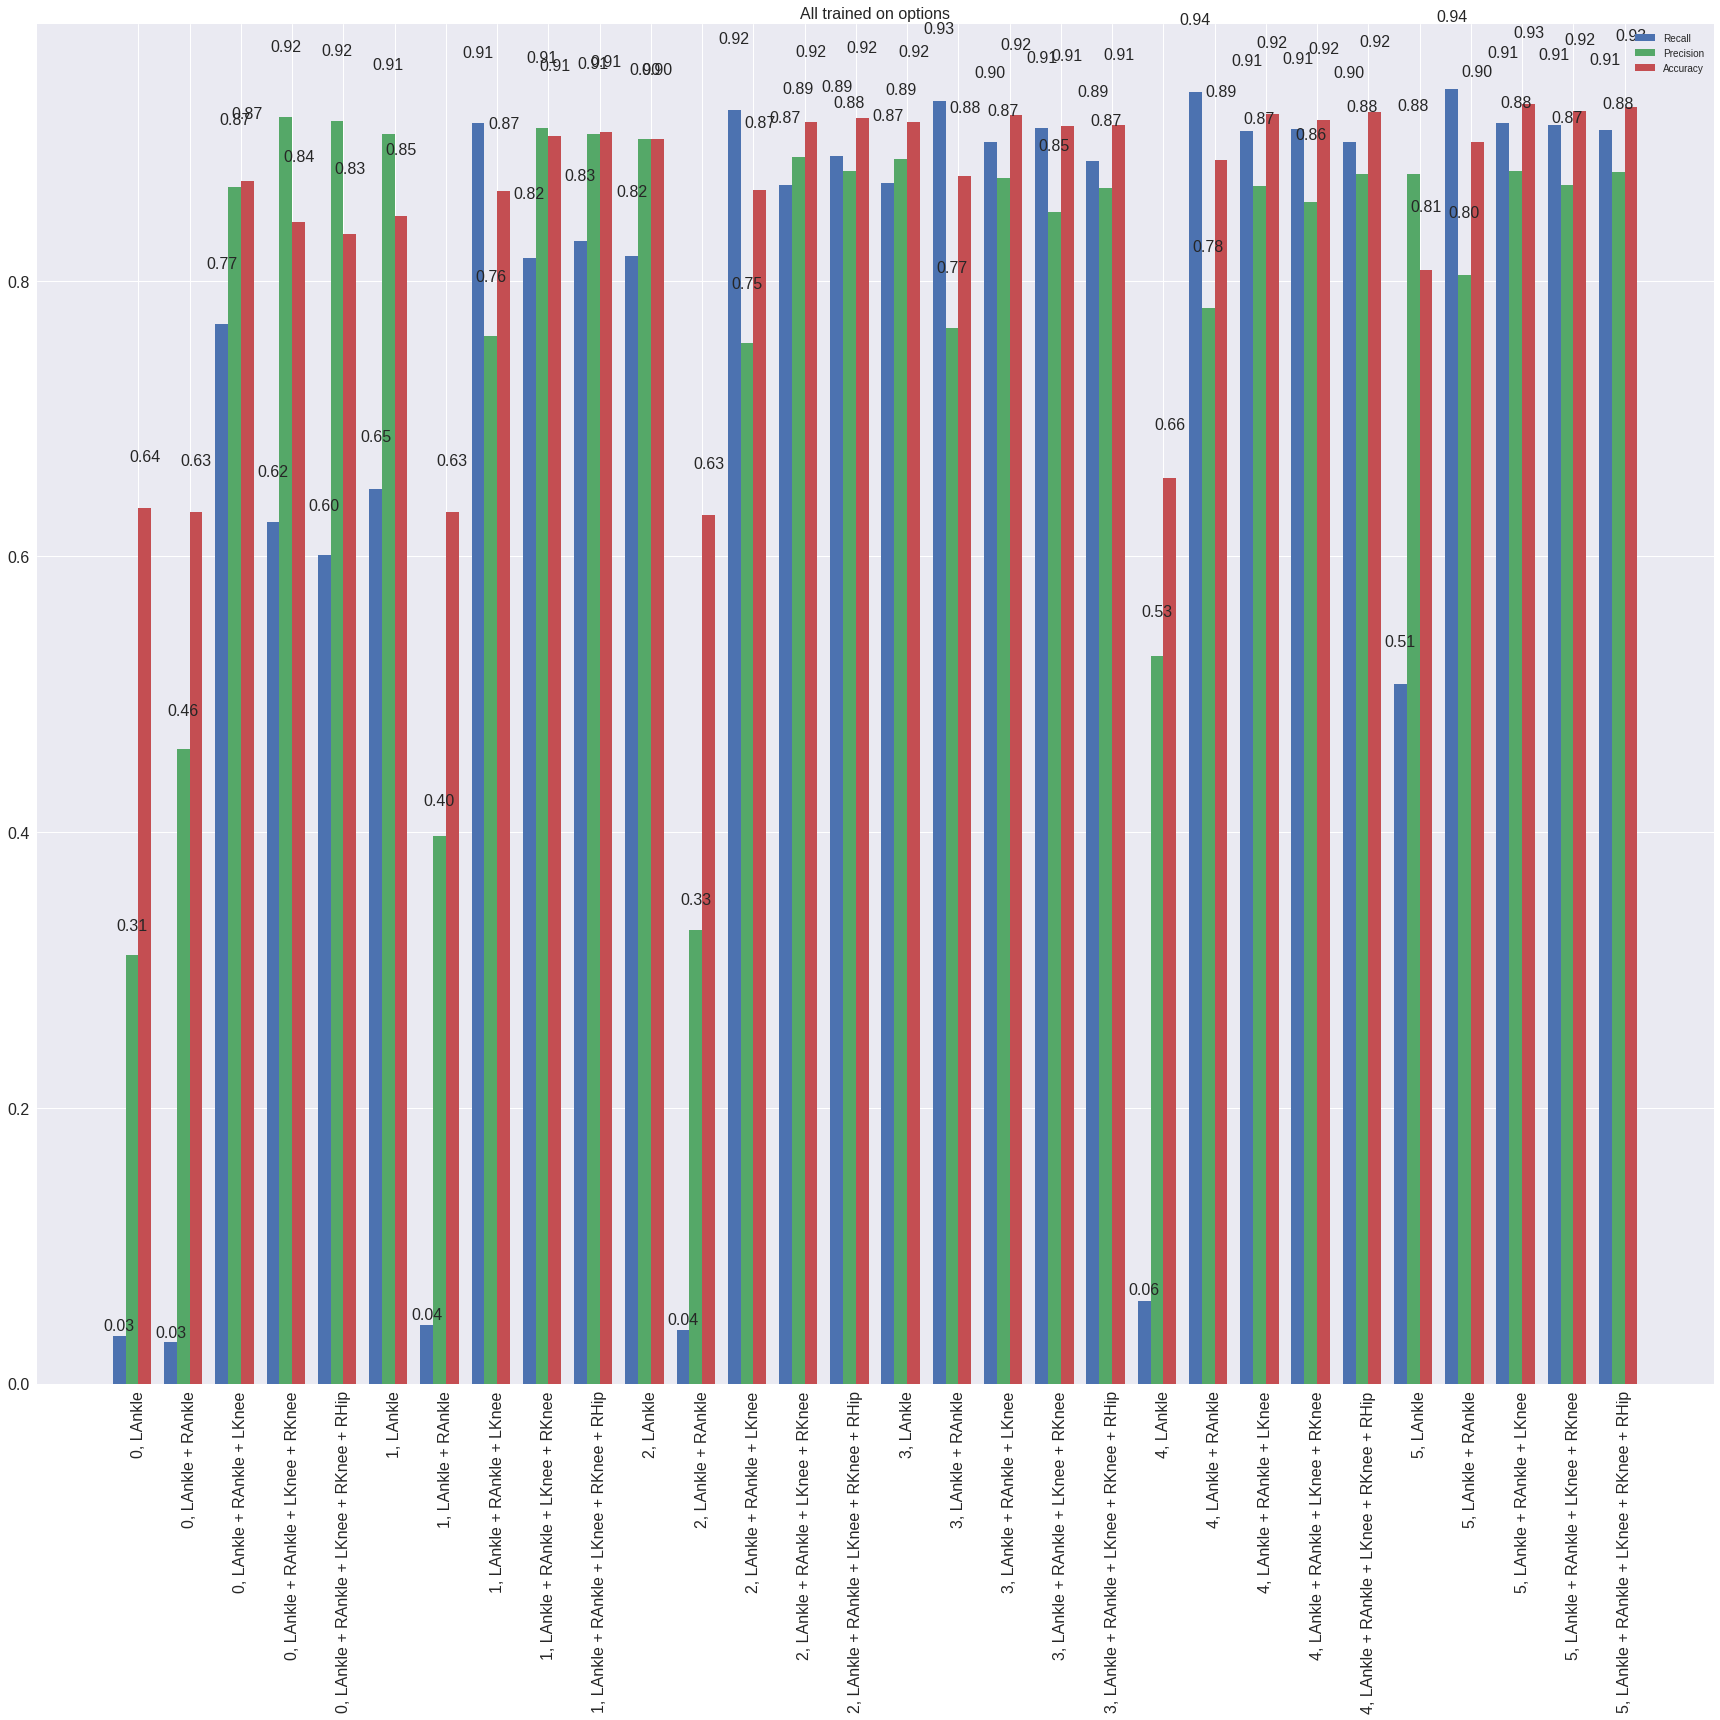

In [22]:
data_dict = {}
for m, m_text in zip(metrics, metric_titles):
    fs = 16
    scores = []
    for o in output:
        y_true = o['targets']
        y_pred = o['predictions']
        scores.append(m(y_true, y_pred))
    data_dict[m_text] = (scores, np.zeros_like(scores))


fig, ax = plt.subplots(1,1, figsize=(24, 24))
fig, ax = barplot(fig, ax, data_dict)
ax.set_xticklabels(opt_tuple_string_list, rotation=90, fontsize=16)
ax.set_title('All trained on options', fontsize=16)
fig.tight_layout()
f_saver.save_fig(fig, 'all_options').next()

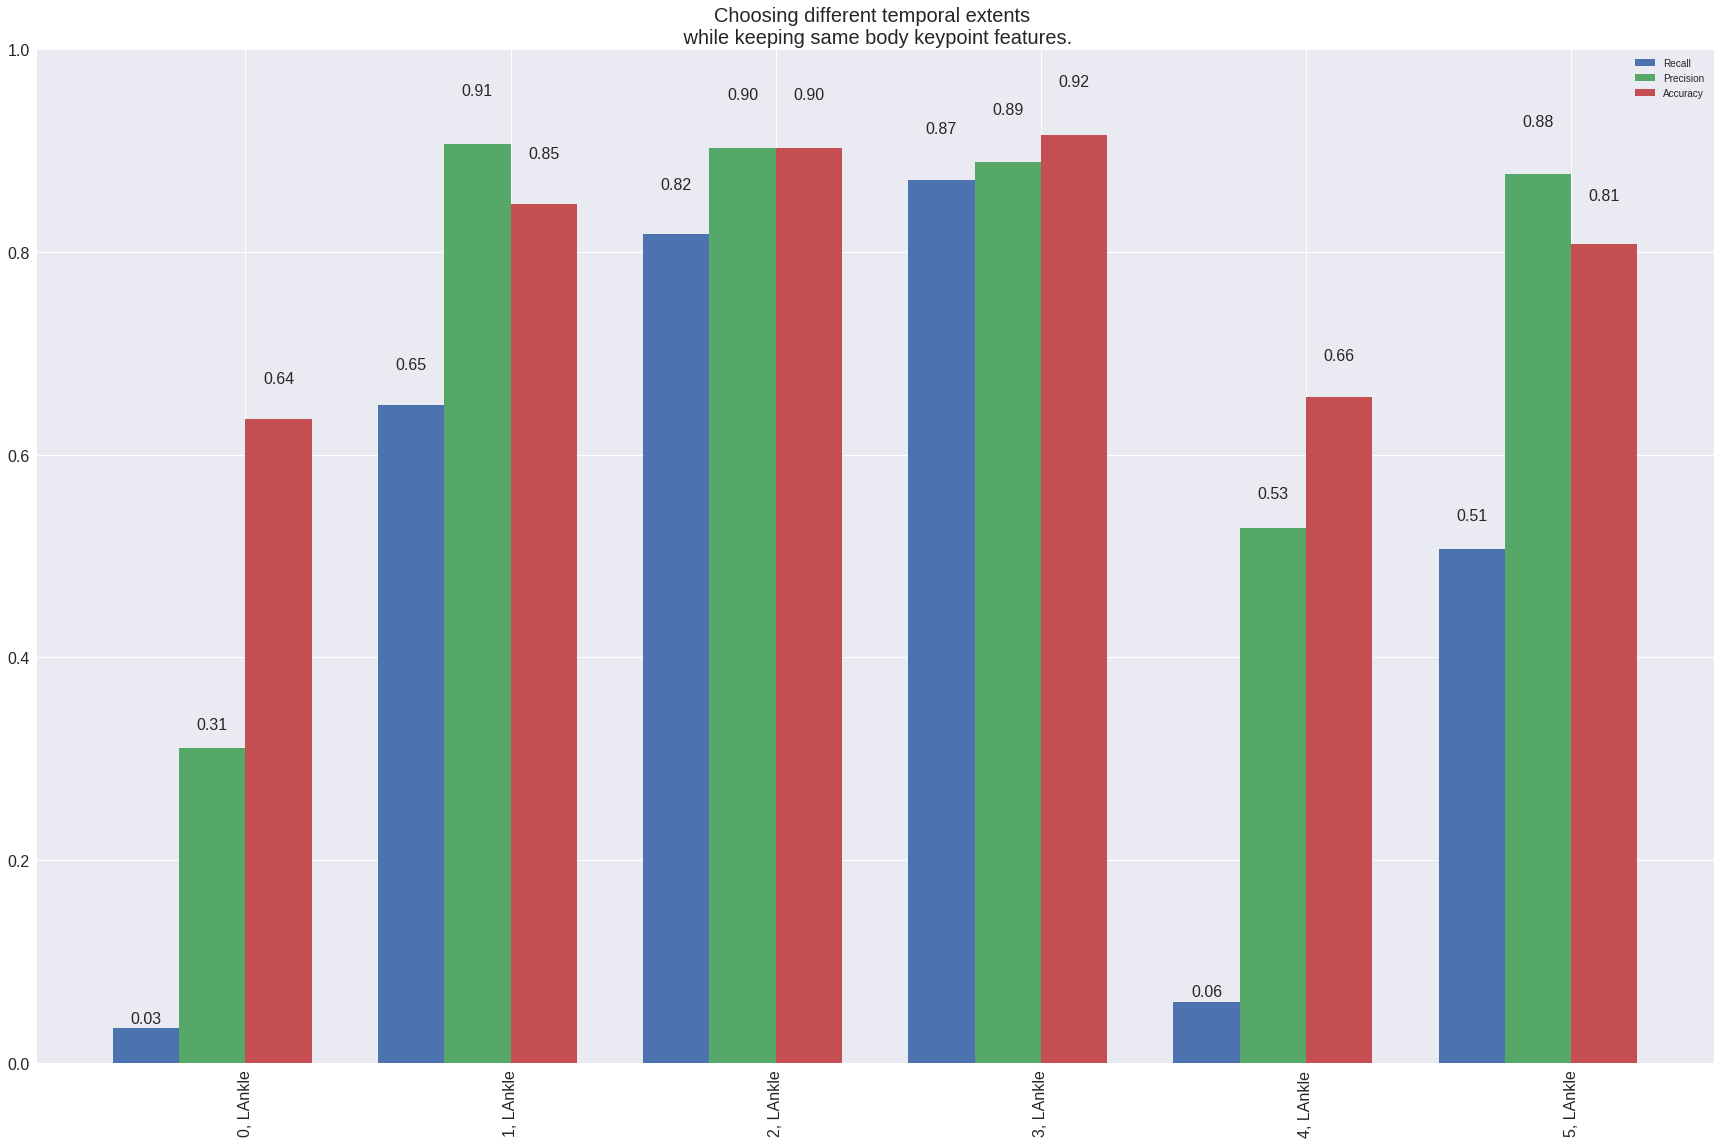

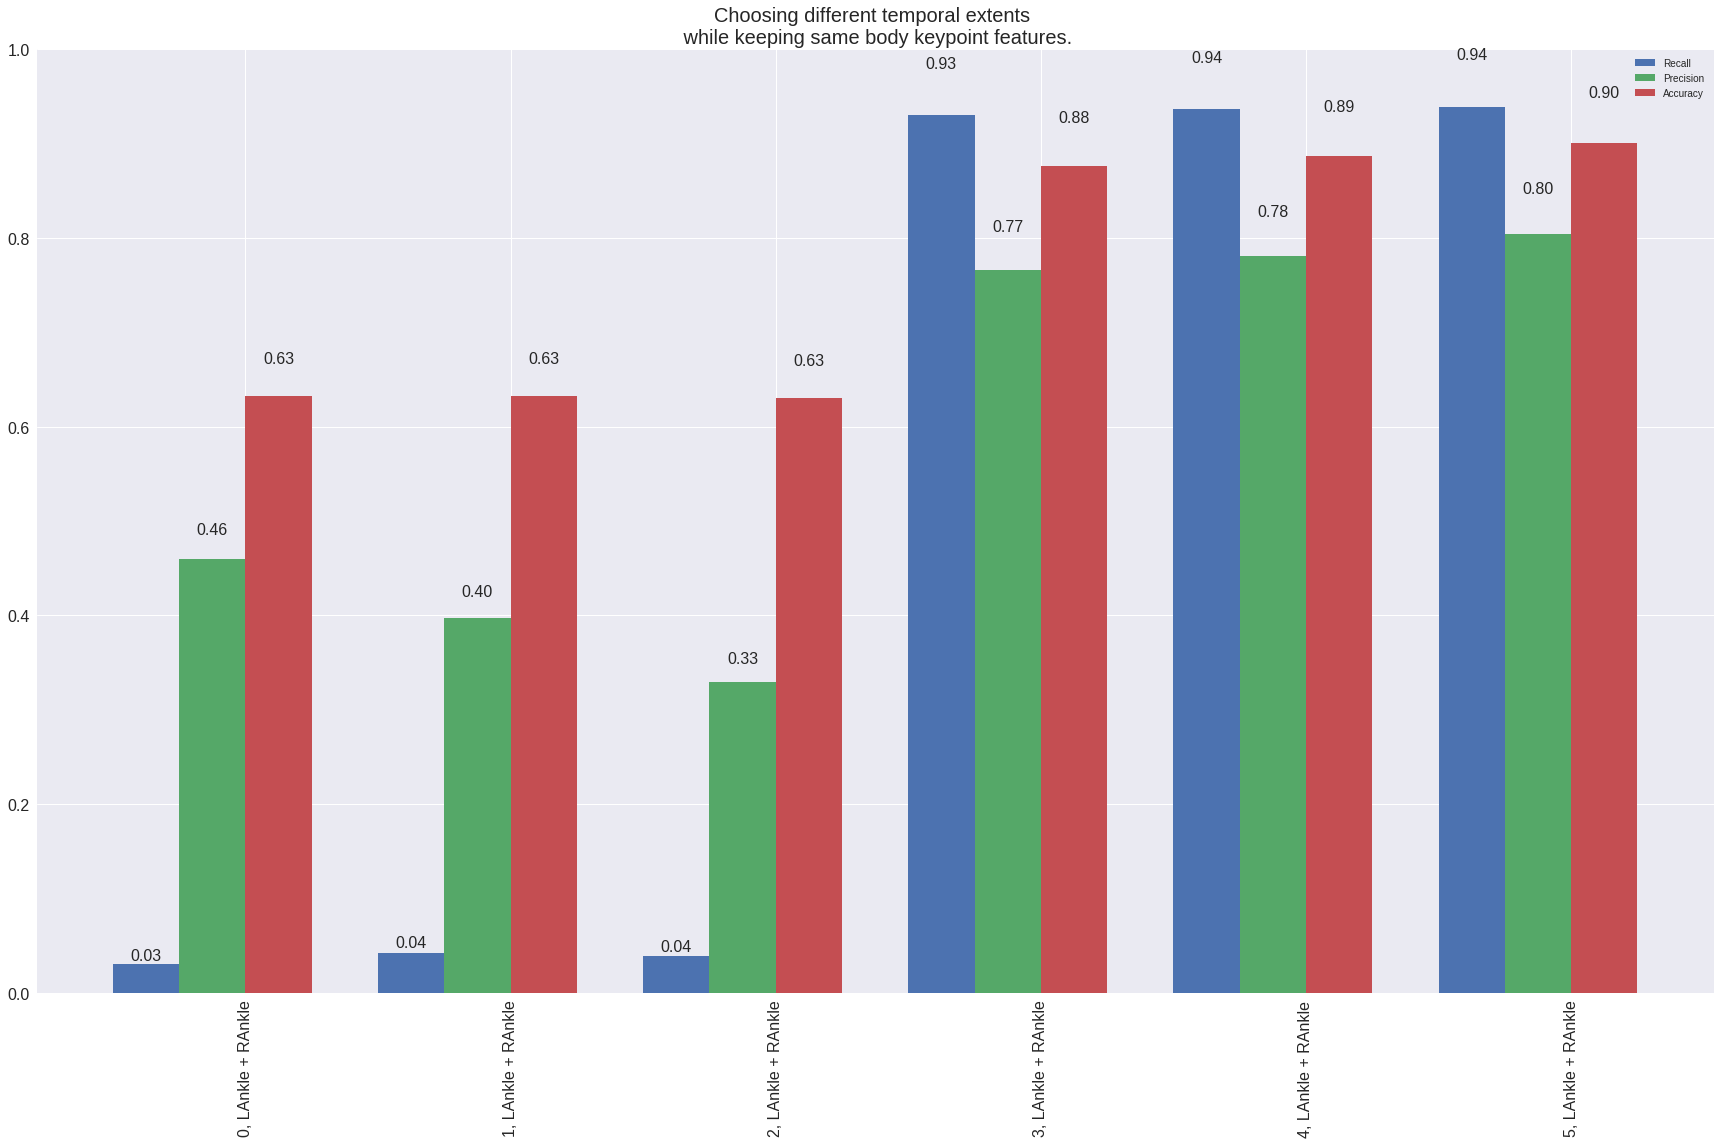

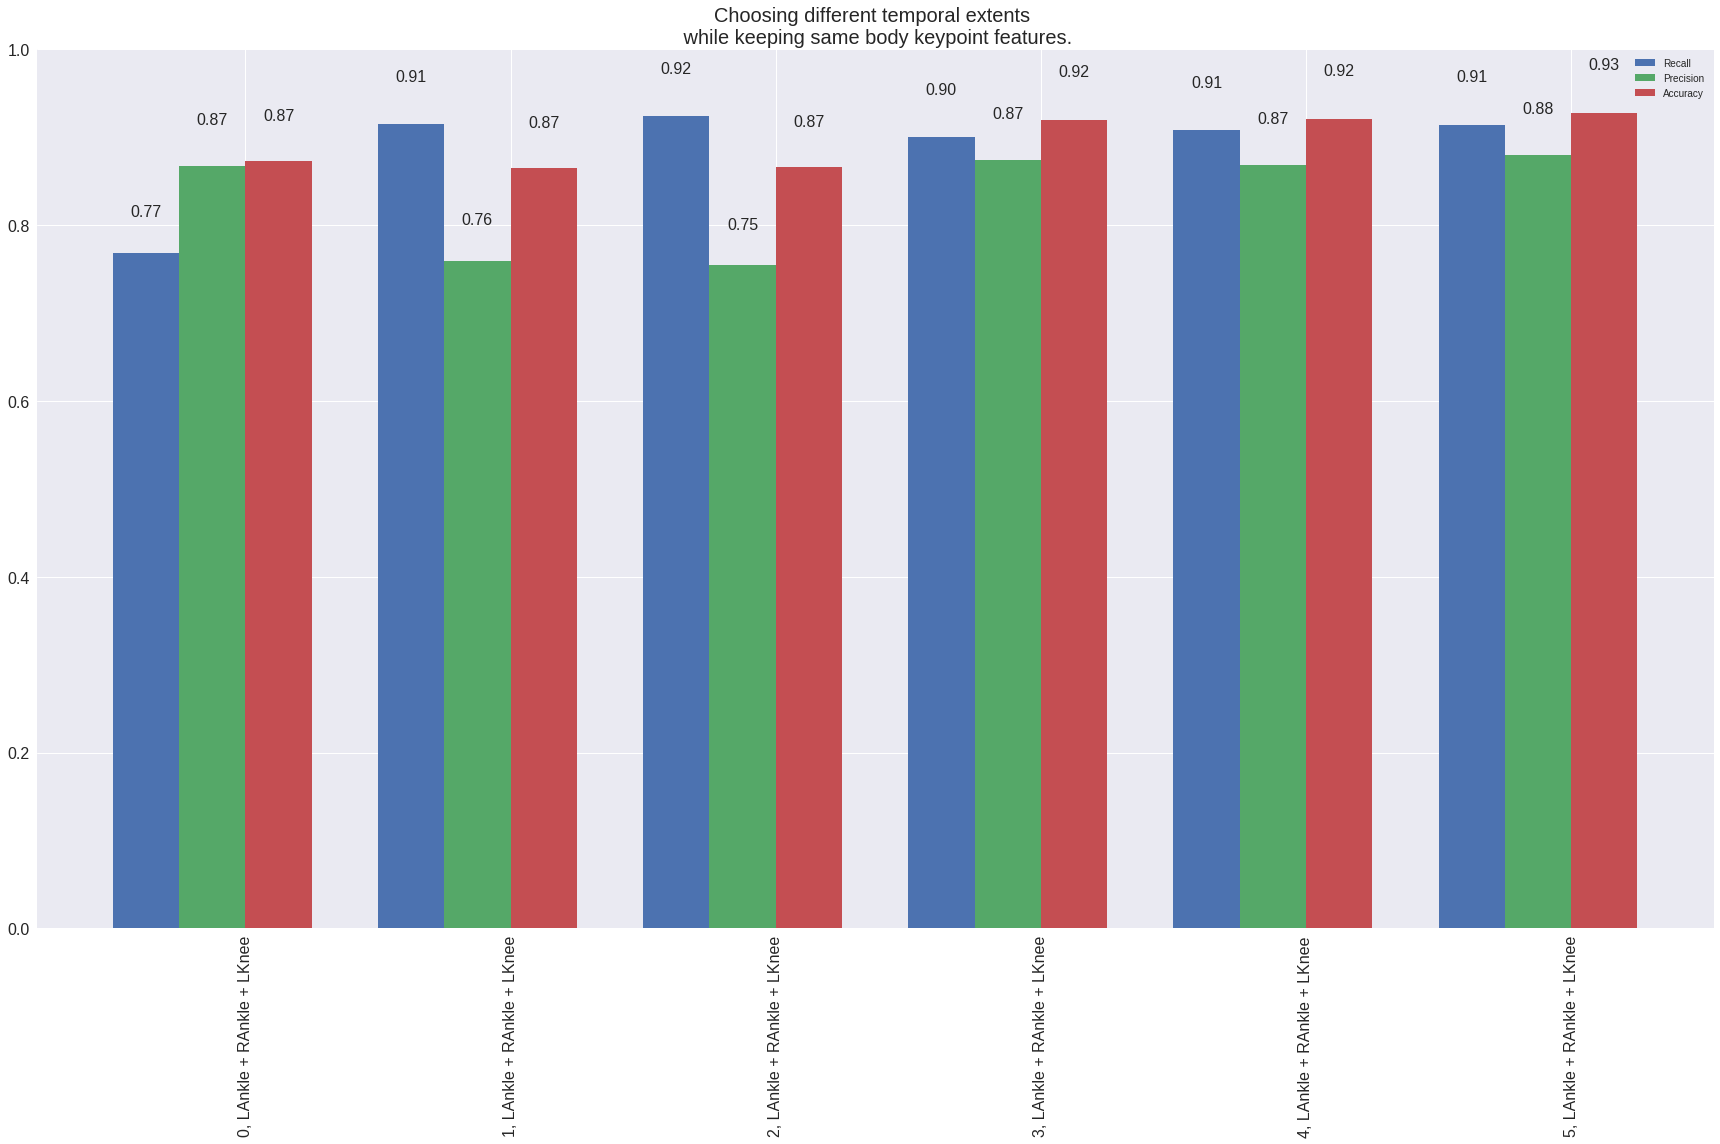

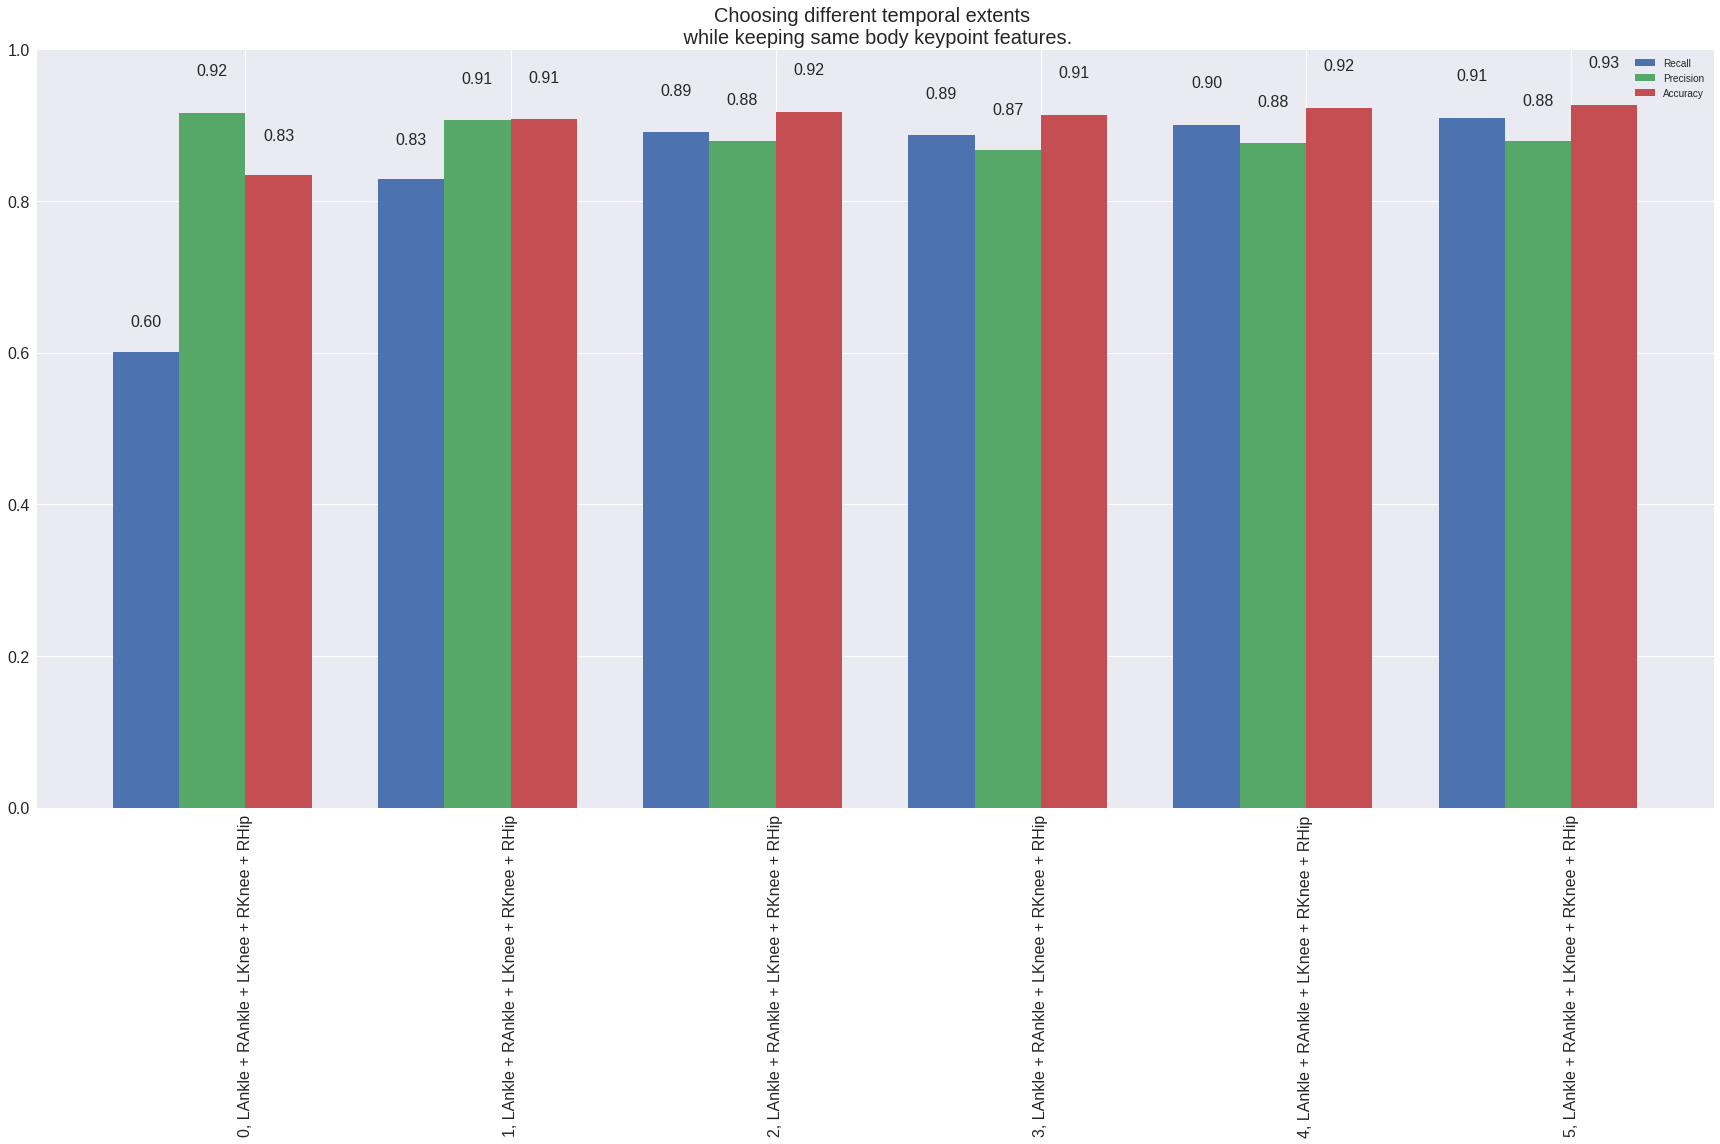

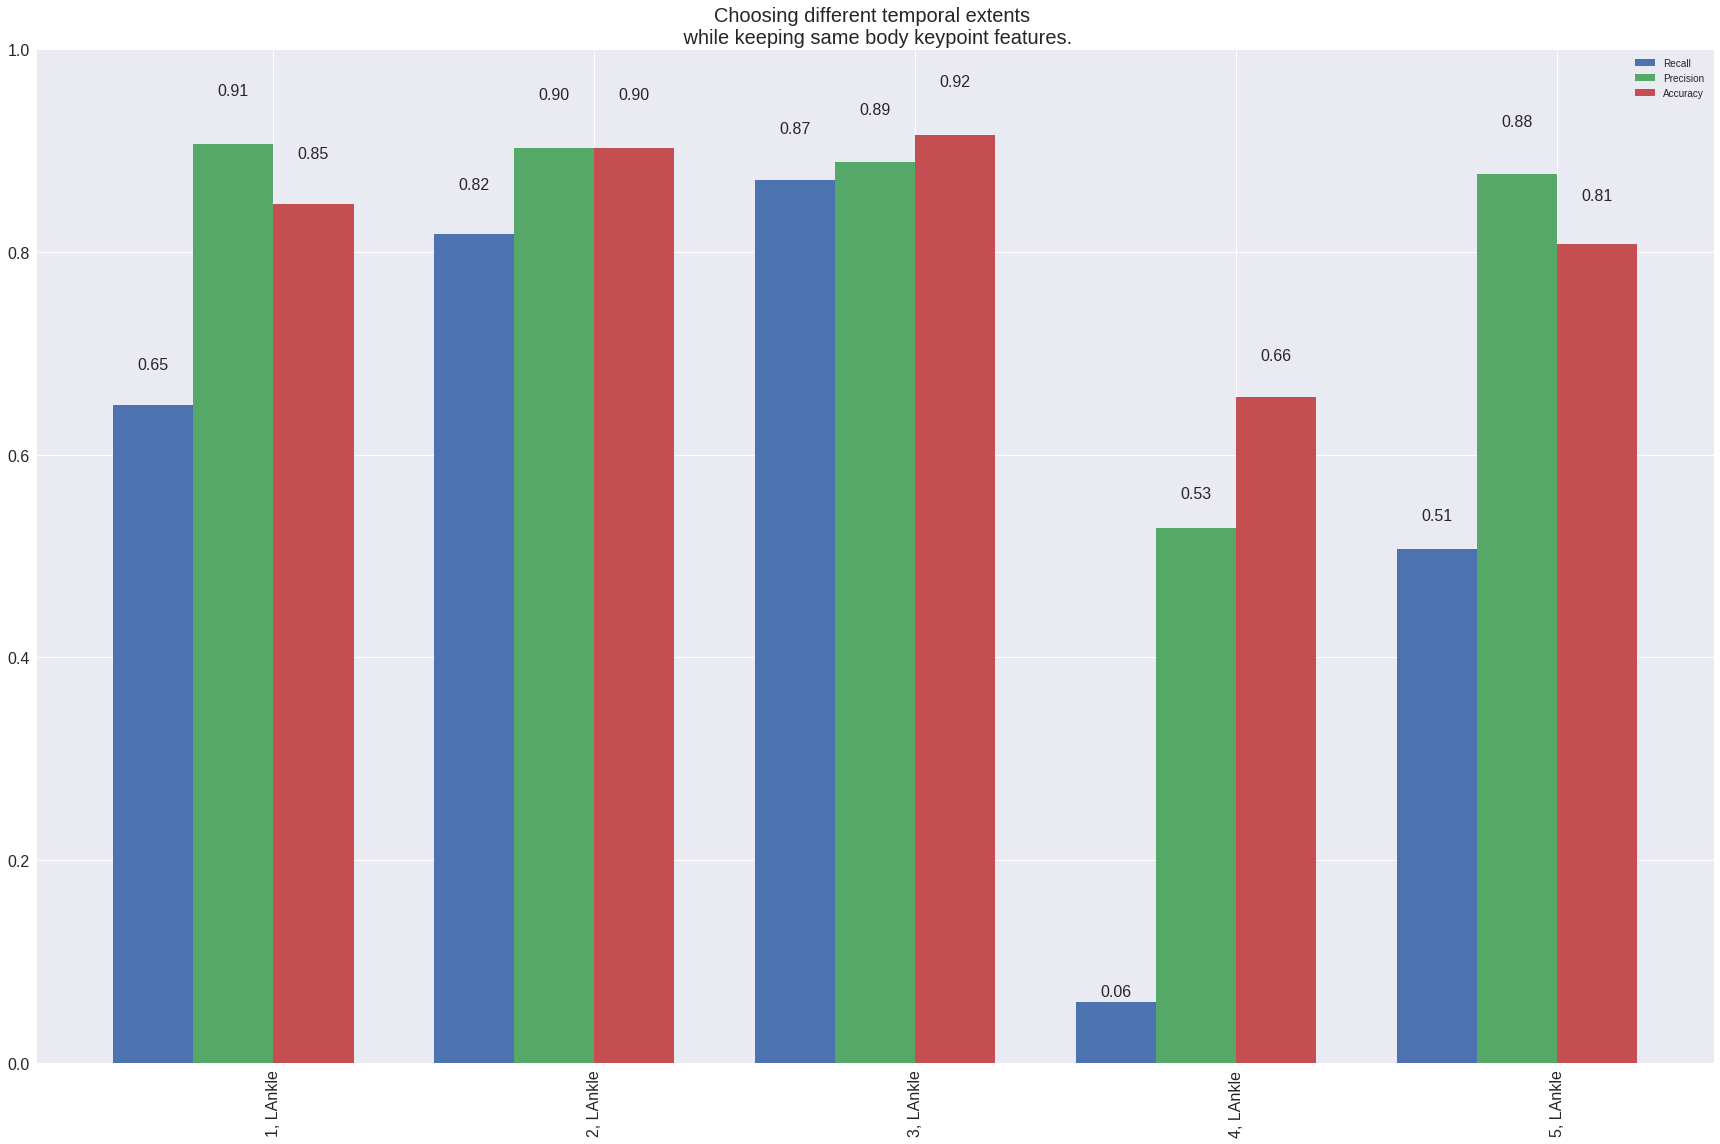

In [23]:
def filter_data_dict(data_dict, i=2, offset=0):
    new_data_dict = {key: (val_tuple[0][offset::i], None) for key, val_tuple in data_dict.iteritems()}
    return new_data_dict


f_saver.set(1)
for offset in [0, 1, 2, 4]:
    new_data_dict = filter_data_dict(data_dict, 5, offset)
    fig, ax = plt.subplots(1,1, figsize=(24, 16))
    fig, ax = barplot(fig, ax, new_data_dict)
    x_ticks = opt_tuple_string_list[offset::i]
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=16)
    ax.set_title('Choosing different temporal extents \n while keeping same body keypoint features.',
                fontsize=20)
    ax.set_ylim([0, 1])
    fig.tight_layout()
    f_saver.save_fig(fig, 'num_keypoints_is_{}'.format(offset+1)).next()